# Distributed Circuit

The `qvm.circuit.DistributedCircuit` object models a circuit that consists of multiple fragments. Each fragment does not have any instruction that connects to another fragment, except `Barrier` (an therefore also `VirtualBinaryGate`). `DistributedCircuit` is a subclass of `qiskit.QuantumCircuit`.

A `DistributedCircuit` can be created from any `QuantumCircuit` by using `from_circuit()`

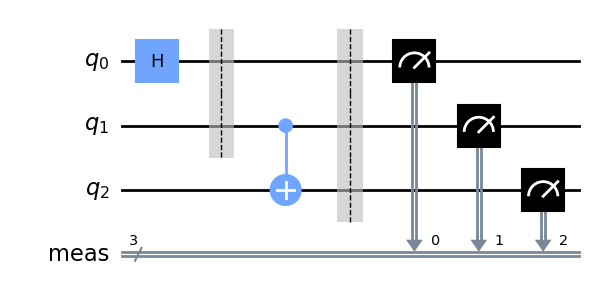

In [1]:
from IPython.display import display
from qiskit import QuantumCircuit
from qvm.virtual_gate import VirtualCZ

circuit = QuantumCircuit(3)
circuit.h(0)
circuit.append(VirtualCZ(), [0, 1], [])
circuit.cx(1, 2)
circuit.measure_all()
circuit.draw('mpl')

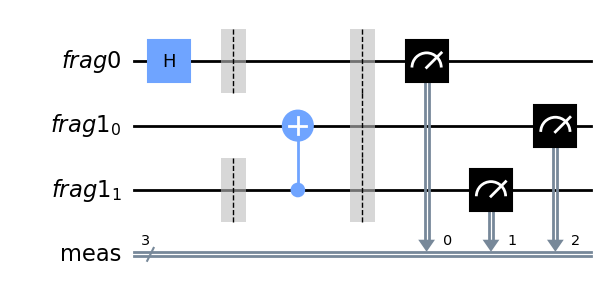

In [2]:
from qvm.circuit import DistributedCircuit

dist_circ = DistributedCircuit.from_circuit(circuit)
dist_circ.draw('mpl')

Note, that a `DistributedCircuit` manages its fragments as `QuantumRegisters` (here `frag0` and `frag1`):

In [3]:
dist_circ.fragments

[QuantumRegister(1, 'frag0'), QuantumRegister(2, 'frag1')]

Since `DistributedCircuit` is a *normal* `QuantumCircuit`, theres nothing preventing a user appending a invalid operation, that would connect two fragments. To check if a `DistributedCircuit` is still valid, us the `is_valid()` method to check. To create a new valid `DistributedCircuit` of the invalid one, just use `from_circuit()` again.

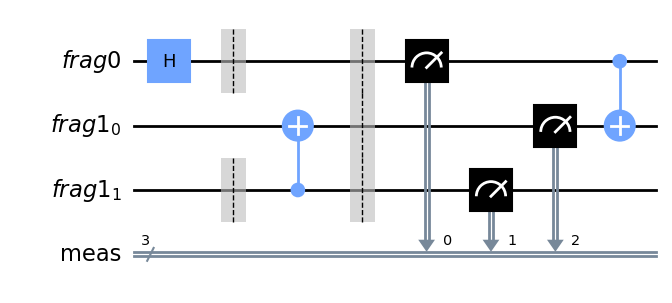

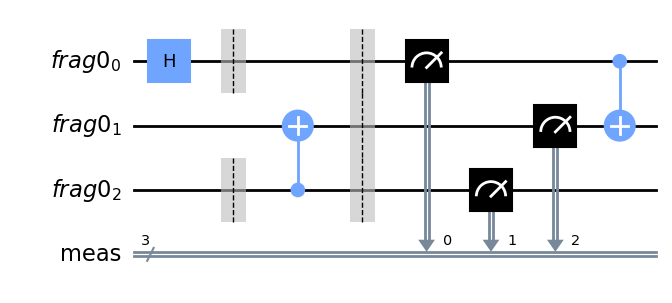

In [4]:
invalid_dist_circ = DistributedCircuit.from_circuit(circuit)
invalid_dist_circ.cx(0, 1)
display(invalid_dist_circ.draw('mpl'))

assert not invalid_dist_circ.is_valid()
valid_dist_circ = DistributedCircuit.from_circuit(invalid_dist_circ)

assert valid_dist_circ.is_valid()
display(valid_dist_circ.draw('mpl'))


You can get each fragment as a circuit:

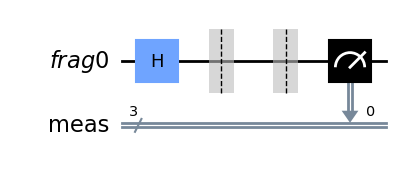

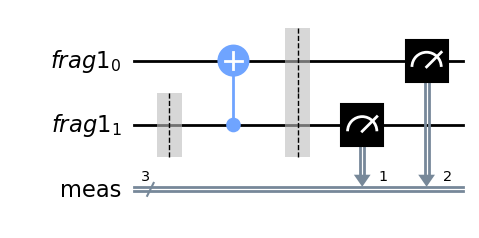

In [5]:

for frag in dist_circ.fragments:
    display(dist_circ.fragment_as_circuit(frag).draw('mpl'))

## Transpiling and Mapping a Distributed Circuit

Since a `DistributedCircuit` is a `QuantumCircuit` object, you can transpile and optimize the circuit as a whole:

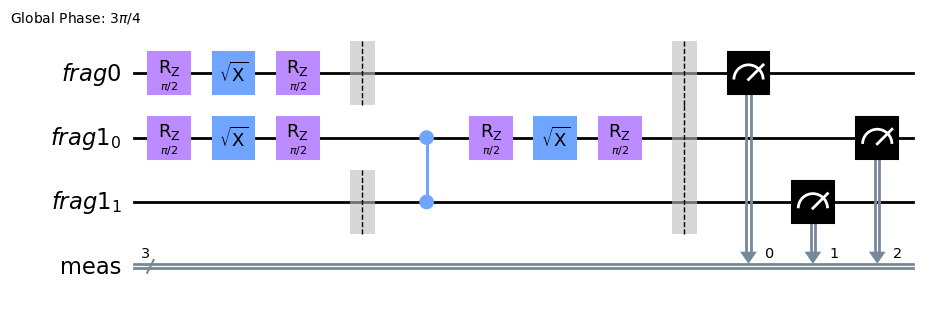

In [6]:
from qiskit import transpile

t_circ = transpile(dist_circ, basis_gates=['cz', 'rz', 'x', 'sx'])
t_circ.draw('mpl')

However, since the fragment should be executed on a set of distributed quantum backends, we can map the qubits of each fragment to physical qubits of a backend. Doing so, the `QuantumRegister` of a fragment is transformed into a `qvm.circuit.MappedRegister`, which in addition to a `QuantumRegister` also has a `backend` and the `initial_layout` that the fragment is going to have on the backend.

In [7]:
from qiskit.providers.aer import AerSimulator, StatevectorSimulator

fragments = dist_circ.fragments
dist_circ.map_fragment(fragments[0], backend=AerSimulator(), initial_layout=[0])
dist_circ.map_fragment(
    fragments[1], backend=StatevectorSimulator(), initial_layout=[0, 1]
)

## Executing a Distributed Circuit

Use the `qvm.executor.execute()` function to execute a `DistribuedCircuit`, accoring to its mapping of fragments. The function returns counts. The executor uses ray to parallelize the execution of fragments.

In [8]:
from qvm.executor import execute

# the default_backend is used if a fragment is not mapped to a backend
counts = execute(dist_circ, default_backend=AerSimulator(), shots=1000)
print(counts)

from qvm.bench.fidelity import fidelity
assert fidelity(circuit, counts) >= 0.99

executing on aer_simulator
executing on statevector_simulator
finished


{'000': 510, '001': 474}